In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tqdm import tqdm
import pickle

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [14]:
dataset_csv = pd.read_csv("/content/Suicidal_tweet_dataset_advanced_corrected (2).csv")
dataset = pd.DataFrame(dataset_csv)
dataset.head()

,Unnamed: 0,text,class,corrected_text
0,74414,dont know7 month self harm free urg get strong...,suicide,don't know7 month self harm free URG get stron...
1,149516,start becom rich start compani becom 16 afford...,non-suicide,Start become rich start company become 16 affo...
2,12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide,Poem haiku megameter hi hello stop fuck say he...
3,14043,ive honestli got idea anymoreit feel everyon f...,suicide,Ive honestly got idea anymore it feel everyone...
4,30673,ever cri like think unfair life cri cant cri e...,non-suicide,Ever cry like think unfair life cry can't cry ...


In [15]:
dataset.shape

(10000, 4)

In [16]:
# Class balance check
print("Class distribution:\n", dataset['class'].value_counts())

# Null value check
print("Null values:\n", dataset.isnull().sum())

Class distribution:
 class
non-suicide    5048
suicide        4952
Name: count, dtype: int64
Null values:
 Unnamed: 0        0
text              1
class             0
corrected_text    0
dtype: int64


In [17]:
# check balancing of Dataset
dataset['class'].value_counts()

,count
class,
non-suicide,5048
suicide,4952


In [18]:

dataset.dropna(subset=['text'], inplace = True)
dataset.dropna(subset=['corrected_text'], inplace = True)
dataset['text'] = dataset['corrected_text']

In [19]:
#shape after removal of null values
print(dataset.shape)

(9999, 4)


In [20]:
dataset.head()

,Unnamed: 0,text,class,corrected_text
0,74414,don't know7 month self harm free URG get stron...,suicide,don't know7 month self harm free URG get stron...
1,149516,Start become rich start company become 16 affo...,non-suicide,Start become rich start company become 16 affo...
2,12484,Poem haiku megameter hi hello stop fuck say he...,non-suicide,Poem haiku megameter hi hello stop fuck say he...
3,14043,Ive honestly got idea anymore it feel everyone...,suicide,Ive honestly got idea anymore it feel everyone...
4,30673,Ever cry like think unfair life cry can't cry ...,non-suicide,Ever cry like think unfair life cry can't cry ...


In [21]:
print(dataset['corrected_text'].shape)
print(dataset['text'].shape)

(9999,)
(9999,)


In [22]:
# Recheck for Null Values
dataset.isnull().sum()


,0
Unnamed: 0,0
text,0
class,0
corrected_text,0


In [23]:
import plotly.express as plx

class_counts = dataset['class'].value_counts().reset_index()
class_counts.columns = ['class', 'count']

plx.bar(class_counts, x='class', y='count', color='class', title="Class Distribution")


In [24]:
dataset['text'] = dataset['corrected_text']
dataset.dropna(subset=['text'], inplace = True)

In [25]:
# Map class labels to 0 (suicide) and 1 (non-suicide)
dataset.loc[dataset['class'] == 'suicide', 'class'] = 0
dataset.loc[dataset['class'] == 'non-suicide', 'class'] = 1
dataset['class'] = dataset['class'].astype(int)
print("Mapped classes:", dataset['class'].unique())

Mapped classes: [0 1]


In [26]:
# Text preprocessing with stemming
port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower().split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
    return ' '.join(stemmed_content)

dataset['stemmend_content'] = dataset['text'].apply(stemming)

In [27]:
# Final
suicide_keywords = ["suicid", "suicide", "suicidal", "kill myself", "want to die", "end my life", "death", "die", "dying", "hopeless", "depressed", "depression", "despair", "pain",
    "suffering", "worthless", "no point", "can’t go on", "tired of living", "no reason to live", "give up", "want to end it", "feel alone", "lonely", "isolated", "empty",
    "numb", "self-harm", "cut", "overdose", "pills", "hang", "jump", "cliff", "gun",  "rope", "blade", "blood", "void", "dark", "black cloud", "no future", "can’t see a way out",
    "life is pointless", "want peace", "escape", "burden", "failure", "useless","not good enough", "hate myself",  "self-hatred", "guilt", "shame", "regret", "no hope", "lost",
    "broken", "can’t cope", "overwhelmed", "anxiety", "fear of living", "fear of death", "fear of failure",  "no one cares", "no one understands",  "no help",  "can’t get help",
    "therapist won’t help", "medication doesn’t work", "mental breakdown", "suicidal thoughts", "plan to die""method", "helium", "plastic bag", "drain cleaner", "fentanyl",
    "carbon monoxide", "poison","slit wrists", "crash car", "jump off bridge",  "no purpose", "life sucks", "misery", "agony", "torment", "trapped","stuck",  "can’t breathe",
    "chest hurts", "cry all the time", "scream inside","want to disappear", "better off dead", "world would be better without me", "family would be better off", "friends don’t care",
    "lost everyone", "abandoned", "betrayal", "trauma", "abuse", "physical pain", "emotional pain", "chronic pain", "can’t sleep", "sleepless nights", "nightmares", "dark thoughts",
    "violent thoughts", "obsession with death", "countdown to death", "last day", "final goodbye", "suicide note", "no one to talk to", "no support", "rejected", "unloved",
    "unlovable", "invisible", "ghost", "hollow", "soul crushed", "heart heavy", "stone in chest", "can’t feel joy", "can’t feel love", "life is a prison", "want to sleep forever",
    "never wake up", "eternal rest", "peace in death", "fear of waking up", "brain damage", "fail at suicide", "scared to fail", "scared to succeed", "guilt about family",
    "hurt loved ones", "selfish to die", "can’t hurt others", "responsibility to live", "obligation to stay", "no escape", "endless struggle", "rock bottom", "can’t climb out",
    "spiral downward", "end the pain", "end it all", "meaningless","i can’t take it", "everything hurts", "take my life", "don’t want to live", "jump off", "tired of life", "done with life",
    "over it", "bleed out","hang myself", "overdose myself", "knife", "drown", "suffocate", "slit", "stab myself", "i wish i were dead", "nobody cares", "stress", "desperation", "anguish",
    "shattered", "falling apart", "nothing left", "want out", "too much", "breaking point", "hollow inside", "dead inside", "no strength", "exhausted", "crying", "sobbing", "panic",
    "collapsing", "numbness", "bleeding", "razor", "shoot myself", "shoot", "gas", "toxic", "fatal", "goodbye", "last breath", "final moments", "done fighting", "let me go", "release me",
    "no way forward", "all over", "over", "finished", "wasting away", "wasting", "beyond help", "irreparable", "devastated", "therapy", "heroin", "overdose", "treat", "deserted", "hopeless",
    "embarrased", "embarass", "embarassing", "cheat", "cheated on", "ruin", "ruined", "dead", "coffin", "low life", "tragic", "overly sad", "past trauma", "pull trigger", "toxic relation",
    "suicide","beg","pathed","escape","fuck","alcohol"," self harm","empathyremors","selfconsci","relief","repress","TRI","diagnose","shotgun","disappear","antipsychotic","mind","guilt","lone",
    "die","insult","illegitimate","shithead","stupidly","Ruin life", "scare","exhaust","goodbye","therapist","cry","dead hit", "dead","fear","hang","anguish","shoot","horrible","Fuckim",
    "jump","balcony","scream","silent","coward","scar","hate", "Gun","failure","depress","relationship","debt","girlfriend","anxious",  "psychiatrist","distraught","conscious","inferior",
    "dumb","physic","diminish", "overwhelm","angry","schizophrenia","miser","molest","harm","frustrate","divorce","fuck", "end","trauma","self-hate","jerk","lost","pointless","worthless",
    "struggle","rest","rest", "annoy","luckless","chance","peace","knife","bullshit","bleed","Jealousim","Nan", "schizophrenia","unhappy","ridicule","mistake","druggy","dumbass","commit",
    "escape","throwaway","pressure","hope","sync","careless","Subreddit","survive","assault", "painkillers","torture","burden","miser","serious","evil","distress","antidepress","Reddit",
    "suicide", "kill myself", "killing myself", "self harm", "depressed", "depression", "hopeless", "worthless", "give up", "end it all", "tired of life", "want to die", "can't go on",
    "no reason to live", "pain", "suffering", "die", "dying", "cut myself", "cutting", "hurt myself", "end my life", "hate myself", "life is pointless", "ending it", "I'm done", "i'm tired",
    "take my life", "why live", "jump off", "pills", "overdose", "slit", "goodbye world", "empty", "lost", "alone", "lonely", "no one cares",  "anxiety", "crying", "hurting", "miserable",
    "despair", "overwhelmed", "helpless", "burden", "fail", "failure", "worthless", "can't sleep", "no hope", "trapped", "done", "numb", "exhausted", "can't take it", "can't handle",
    "hate life", "i'm not okay", "i give up", "nothing matters", "it's too much", "can't breathe", "sick of this", "hate everything", "i'm broken", "falling apart", "wish i could disappear",
    "don’t want to wake up", "no one understands", "not enough", "i failed", "everyone hates me", "suffocating", "wish I was gone", "just want peace", "can't keep going", "it hurts",
    "everything hurts", "so tired", "so alone", "can’t take the pain", "feel so lost", "can’t escape", "feel worthless","feel like a burden", "emptiness", "failure", "numb", "exhaustion",
    "despair", "overwhelmed", "broken", "worthlessness", "regret", "self-loathing", "void", "loneliness", "lost all hope", "no reason to continue", "everything feels pointless",
    "wish I could freeze time", "life feels empty", "tired of pretending", "can’t stop crying", "I’m broken inside", "nothing makes sense anymore", "don’t want to wake up tomorrow",
    "everything hurts too much", "want to escape this suffering", "feel like I’m drowning", "want to disappear forever","hopelessness", "invisible", "broken", "anxious","I'm tired",
    "wish I was never born", "don’t see a way out", "I’m exhausted from life", "can’t take the pain anymore", "cant afford", "don't real", "goodbye", "sacrifice", "leave", "reach end",
    "Help", "drunk", "meth","methapthamine","jail","I'm done","sad feel","hurt","physic","hell", "problem","burn","burn alive","surgery","paralysis","unable","suffer","assualt","pill","parent",
    "parental","horrible","heart break","blame","dysphoria","top floor","jump","one talk","nobody", "threat", "lost", "void","don't want", "fail","bull","weak","attempt","depersonalization",
    "unbearable", "I'm worst", "I'm burdern", "useless", "unless", "want talk", "sexual assualt", "dead","hang", "worry", "worried", "sorry", 'mommy', "daddy", "weird", "wrong", "ill", "broke",
    "freak", "creepy", "destroy", "wasted", "not left", "overdose", "divorce", "creep", "bastard", "trouble", "apology", "harass", "self harm", "shut", "restless", "lost mind", "struggle",
    "lonely", "disappoint","disappointment","Im sorry", "asshol", "disappear", "ruin", "ruined", "hate", "disappear","loser", "evil", "coronavirus","hate", "Hate", "I'm exhaust", "need someone",
    "family probelm", "Im tire", "insecure","discomfort","unfair","don't want deal","homeless","lost hope", "garbage", "burden", "Im useless", "I'm killer", "I'm far gone", "suicide feelings",
    "end life", "don't want","anymore","disgust", "pointless", "quit", "sturggle", "worry","homesick", "End life",  "Cut", "shit", "ill jump", "can't bare", "exit", "note",  "I've never",
    "hate", "hate love","hate people", "stuck", "i'm sick", "I'm scare", "wish talk somebody", "scare", "anymore","hotline", "fail", "feel guilty", "last time", "break", "leaving this world",
    "anymore", "breakdowm", "isn't enough", "Cant take anymore", "I'm done", "I'm narcissist", "falut", "faluty", "panic attack",
    ]
dataset['keyword_flag'] = dataset['stemmend_content'].apply(lambda x: int(any(kw in x for kw in suicide_keywords)))

In [28]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.90,
    ngram_range=(1, 3),
    sublinear_tf=True,
)
X_tfidf = vectorizer.fit_transform(dataset['stemmend_content'])

#keyword_flags = dataset['keyword_flag'].values

In [29]:
X_combined = hstack([X_tfidf, dataset[['keyword_flag']].values])
Y_label = dataset['class']

In [30]:
print("Feature matrix shape:", X_combined.shape)
print("Labels shape:", Y_label.shape)

Feature matrix shape: (9999, 10001)
Labels shape: (9999,)


In [31]:

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_combined, Y_label, test_size=0.2, random_state=52)
print("x_train:", x_train.shape, "x_test:", x_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

# Ensure int type for training
y_train = y_train.astype('int')
y_test = y_test.astype('int')


x_train: (7999, 10001) x_test: (2000, 10001)
y_train: (7999,) y_test: (2000,)


In [32]:
# Assuming you want to use x_train and x_test from cell 22
# train_data and test_data are actually called x_train and x_test

# Convert the sparse matrix to dense arrays, then calculate length of each document
train_text_length = [len(doc.split()) for doc in dataset.loc[y_train.index, 'stemmend_content']] # Calculate length of each document in training set
test_text_length = [len(doc.split()) for doc in dataset.loc[y_test.index, 'stemmend_content']]    # Calculate length of each document in testing set

cleaned_train_text = dataset.loc[y_train.index, 'stemmend_content']  # Get the cleaned text for the training set
cleaned_test_text = dataset.loc[y_test.index, 'stemmend_content']     # Get the cleaned text for the testing set

# train_text_length and test_text_length now contain the lengths of each document
# cleaned_train_text and cleaned_test_text contain the cleaned text for each document

<ipython-input-33-d384900dcbe4>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




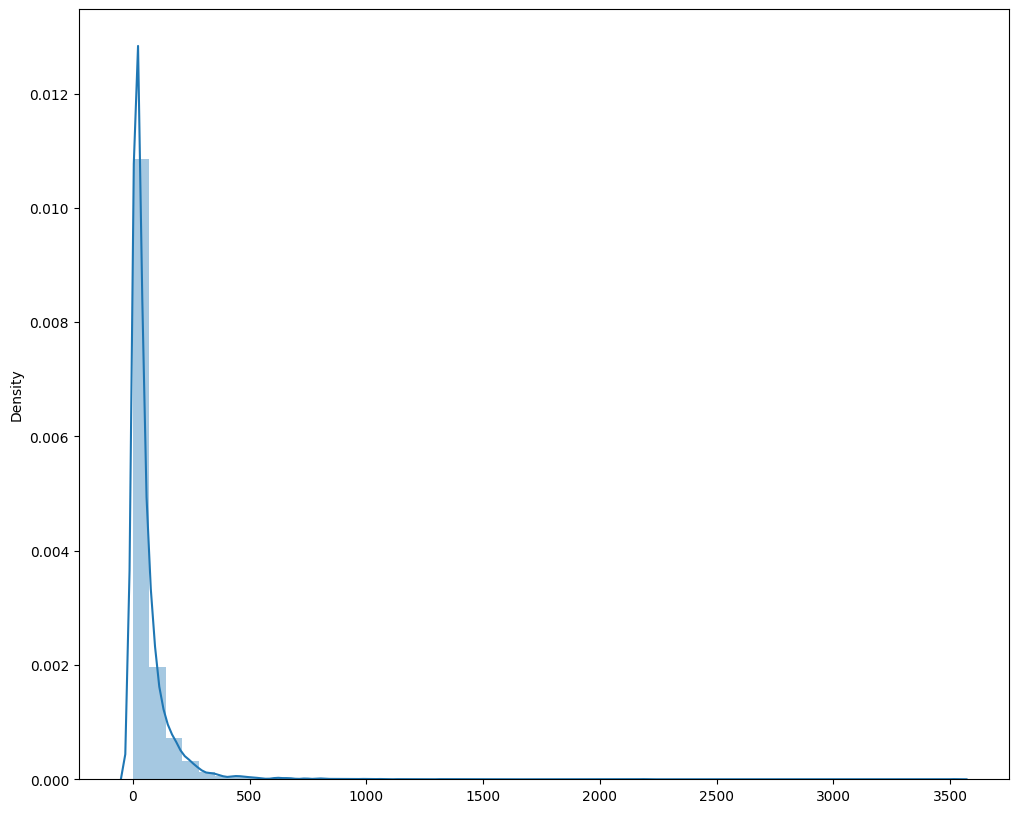

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()


In [34]:
print(y_train.shape)
print(y_test.shape)

(7999,)
(2000,)


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [36]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

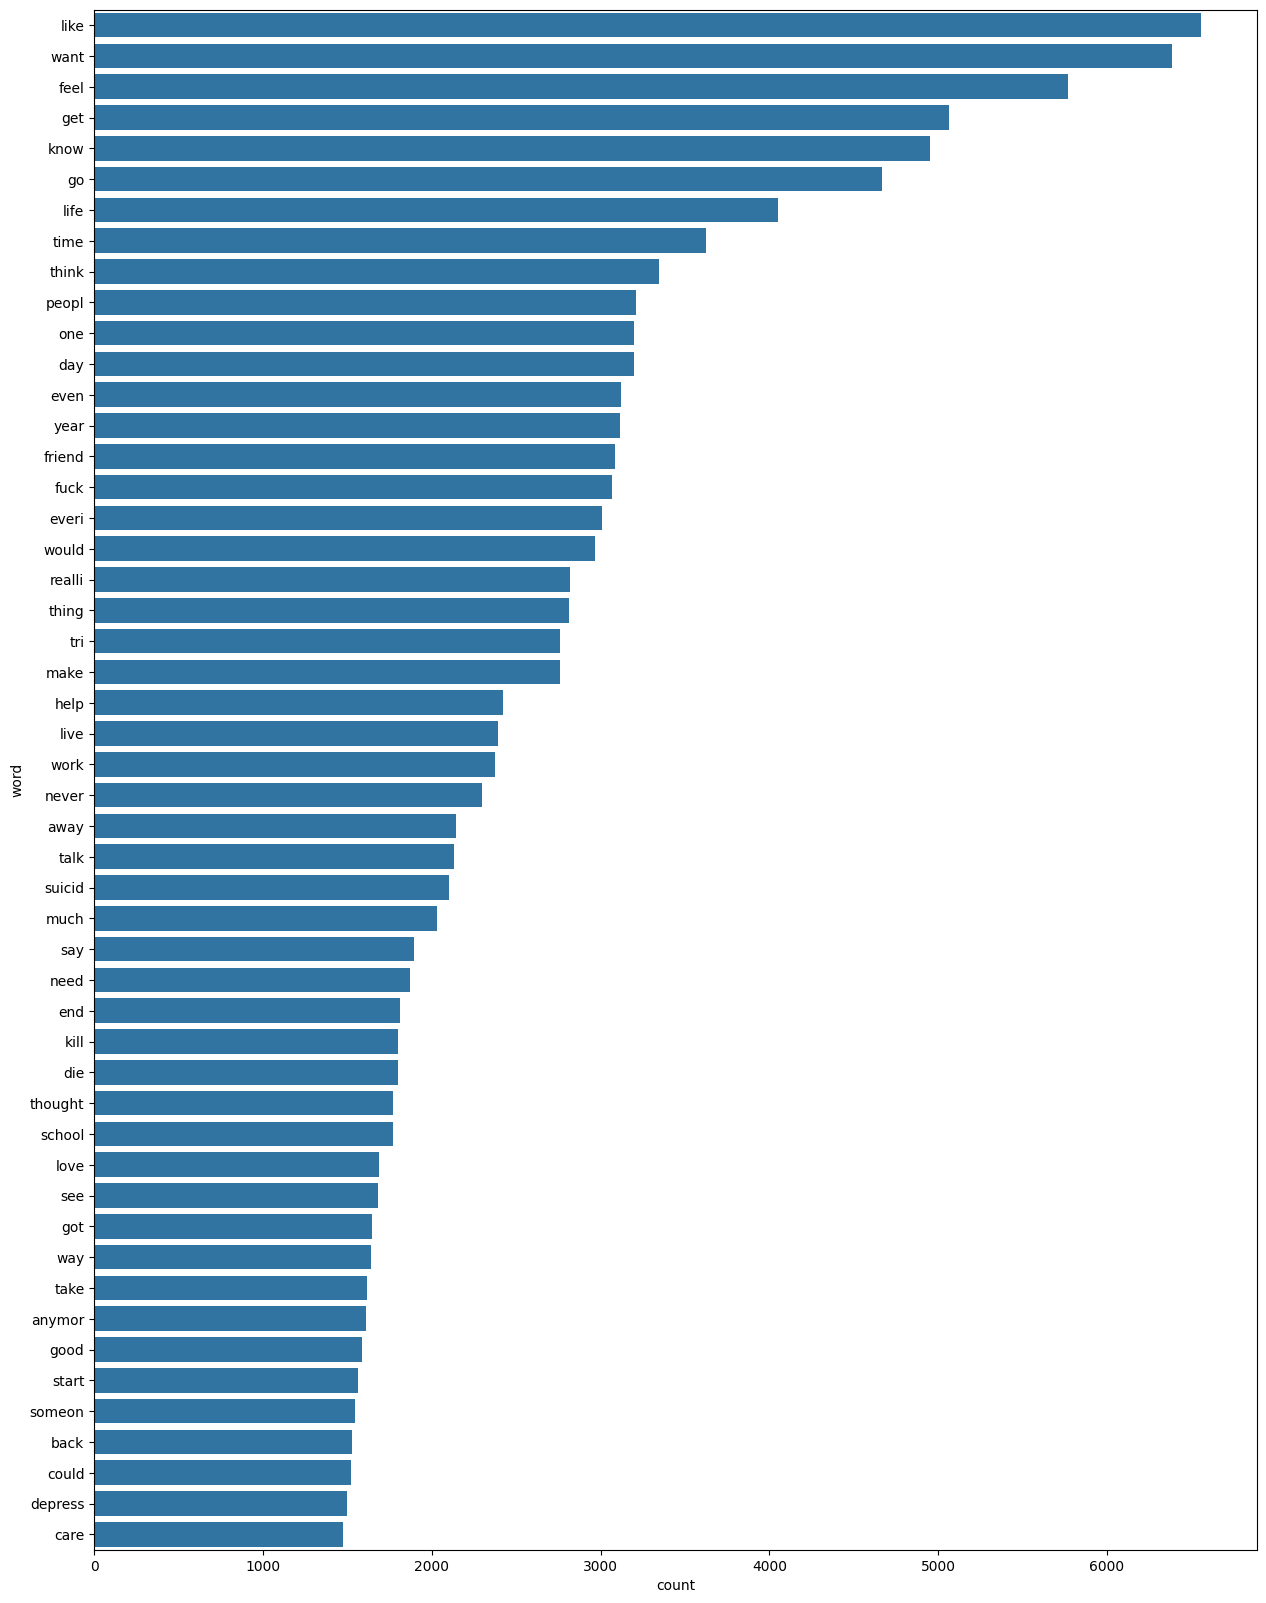

In [37]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

In [38]:
# HyperParameter tunning
param_grid = {
    'penalty' : ['l1','l2'],
    'solver' : [ 'liblinear','saga'],
    'C' : [0.1,0.2,0.5,0.8,1,2,],
}

In [39]:
lr = LogisticRegression(max_iter = 1000)
grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring='accuracy' )
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 0.2, 0.5, 0.8, 1, 2],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [40]:
# Best Parameters
print(grid_search.best_params_)

{'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}


In [41]:
# taking best model
model = grid_search.best_estimator_

In [42]:
# check overfitting and training accuracy
prediction_train = model.predict(x_train)
score_train = accuracy_score(prediction_train, y_train)
print(score_train)

0.963120390048756


In [43]:
# Prediction on test
prediction_test = model.predict(x_test)
score_test = accuracy_score(prediction_test, y_test)
print(score_test)

0.9255


In [45]:
# Evaluation
# Assuming 'prediction_test' from cell 43 holds the model predictions
print("\n📊 Classification Report:\n", classification_report(y_test, prediction_test))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_test, prediction_test))


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      1009
           1       0.91      0.94      0.93       991

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

🧮 Confusion Matrix:
 [[919  90]
 [ 59 932]]


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import plotly.express as px
# Best model
best_lr = grid_search.best_estimator_

# Predictions
# y_train_pred = best_lr.predict(x_train)
# y_test_pred = best_lr.predict(x_test)

# Count predictions
train_pred_counts = pd.Series(y_train).value_counts()
test_pred_counts = pd.Series(y_test).value_counts()

# Convert to DataFrames for Plotly
df_train_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [train_pred_counts.get(1, 0), train_pred_counts.get(0, 0)],
    'Dataset': 'Train Predictions'
})

df_test_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [test_pred_counts.get(1, 0), test_pred_counts.get(0, 0)],
    'Dataset': 'Test Predictions'
})

# Combine DataFrames
df_lr_gantt = pd.concat([df_train_pred, df_test_pred], ignore_index=True)

# Plot
fig = px.bar(df_lr_gantt,
             x="Finish",
             y="Dataset",
             color="Task",
             orientation='h',
             title="Logistic Regression Predictions: Suicidal vs Non-Suicidal",
             labels={'Finish': 'Predicted Count'},
             color_discrete_map={'Suicidal': '#00dddf', 'Non-Suicidal': '#000fbb'})

fig.update_layout(barmode='stack')
fig.show()


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import plotly.express as px
# Best model
best_lr = grid_search.best_estimator_

# Predictions
y_train_pred = best_lr.predict(x_train)
y_test_pred = best_lr.predict(x_test)

# Count predictions
train_pred_counts = pd.Series(y_train_pred).value_counts()
test_pred_counts = pd.Series(y_test_pred).value_counts()

# Convert to DataFrames for Plotly
df_train_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [train_pred_counts.get(1, 0), train_pred_counts.get(0, 0)],
    'Dataset': 'Train Predictions'
})

df_test_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [test_pred_counts.get(1, 0), test_pred_counts.get(0, 0)],
    'Dataset': 'Test Predictions'
})

# Combine DataFrames
df_lr_gantt = pd.concat([df_train_pred, df_test_pred], ignore_index=True)

# Plot
fig = px.bar(df_lr_gantt,
             x="Finish",
             y="Dataset",
             color="Task",
             orientation='h',
             title="Logistic Regression Predictions: Suicidal vs Non-Suicidal",
             labels={'Finish': 'Predicted Count'},
             color_discrete_map={'Suicidal': '#00dddf', 'Non-Suicidal': '#000fbb'})

fig.update_layout(barmode='stack')
fig.show()


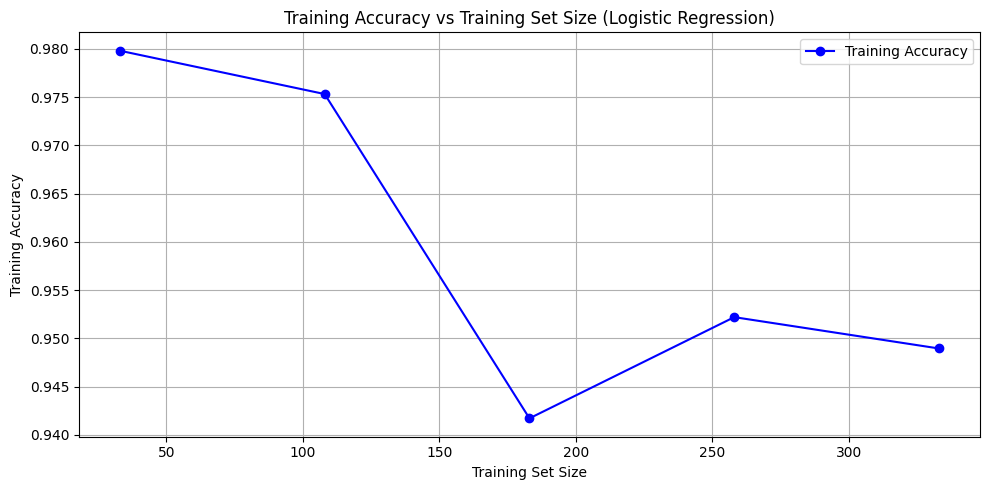

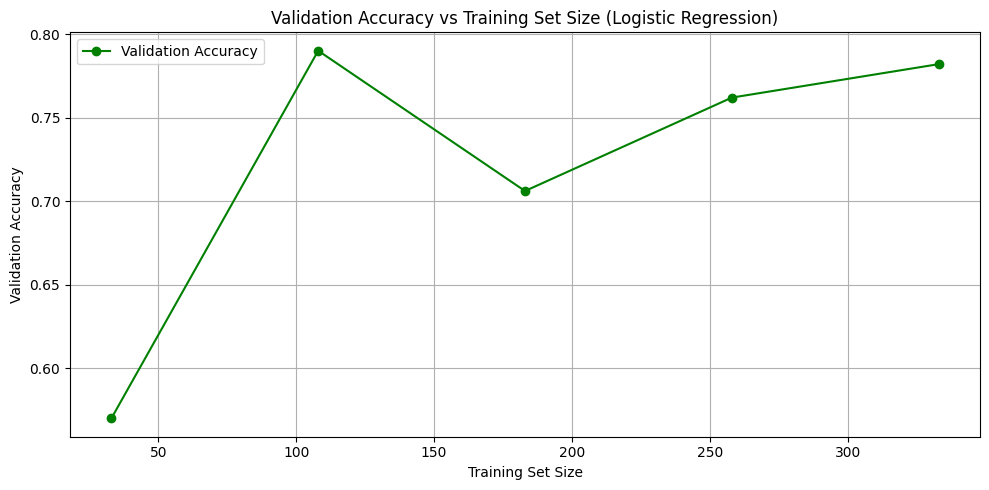

In [48]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model


# Optional: use a subset of data for faster execution
X_sample = x_train[:500]
y_sample = y_train[:500]

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    lr,
    X_sample,
    y_sample,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Calculate mean scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot 1: Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_scores_mean, color='blue', marker='o', label='Training Accuracy')
plt.title('Training Accuracy vs Training Set Size (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('Training Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, test_scores_mean, color='green', marker='o', label='Validation Accuracy')
plt.title('Validation Accuracy vs Training Set Size (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


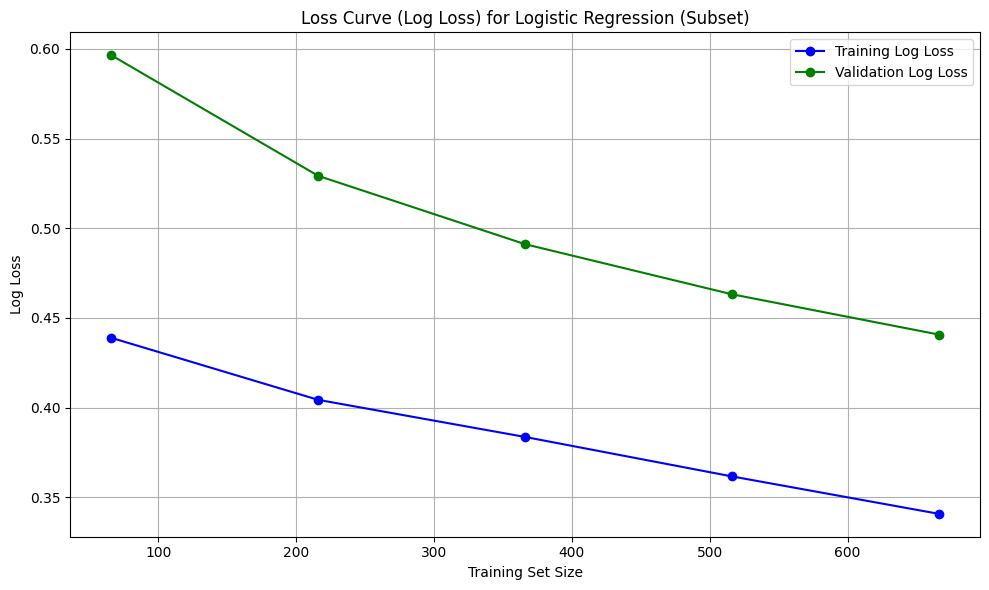

In [49]:

# Use a subset of training data
X_small = x_train[:1000]
y_small = y_train[:1000]

# Learning curve for Log Loss
train_sizes, train_scores, test_scores = learning_curve(
    lr,
    X_small,
    y_small,
    cv=3,
    scoring='neg_log_loss',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Convert to positive log loss
train_loss = -np.mean(train_scores, axis=1)
test_loss = -np.mean(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_loss, label='Training Log Loss', marker='o', color='blue')
plt.plot(train_sizes, test_loss, label='Validation Log Loss', marker='o', color='green')
plt.title('Loss Curve (Log Loss) for Logistic Regression (Subset)')
plt.xlabel('Training Set Size')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
import joblib

# Save model & vectorizer in /kaggle/working/
joblib.dump(model, '/content/sample_data/model.pkl')
joblib.dump(vectorizer, '/content/sample_data/vectorizer.pkl')

['/content/sample_data/vectorizer.pkl']